# Plotting pMOS I-V Data and Simulations

**Caveat:** This is a preliminary example to illustrate the opportunity of measuring I-V characteristics. Some comparison is included to the simulated results, but given an public-domain model card is used that is not really optimized for this technology, the matching is not expected to be very good. Some basic analysis was done to try to make simulations match measurements, but it is very limited and incomplete. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [8.0, 8.0]
%matplotlib inline

import pickle
import os

import PyLTSpice as pyLT

import itertools
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

In [3]:
def plot_data(ax, data, color='b', marker='-o', name='', R_meas=94):
    for i in data.keys():
        VGS = data[i]["VGS"]
        if i == 0:
            ax.plot(data[i]["VDS"], np.array(data[i]["IDS"])*1000/R_meas, marker, color=color, label=name)
        else:
            ax.plot(data[i]["VDS"], np.array(data[i]["IDS"])*1000/R_meas, marker, color=color)
    ax.set_xlabel("VDS [V]")
    ax.set_ylabel("IDS [mA]")
    ax.grid(True)
    ax.legend()

def plot_data_collection(ax, data_collection, R_meas=94):
    for set_name in data_collection.keys():
        plot_data(ax, data_collection[set_name])

## pMOS 1x Diode-Connected Devices

There are two diode connected pMOS devices on the chip as part of the current mirrors. We first measure their IDS-VGS characteristics. 

### Collecting the Simulation Data

In [4]:
sim_filenames = [ "sims/pmos_IV_4x_1x_diode_IDS_VGS.raw" ]
log_filenames = [ "sims/pmos_IV_4x_1x_diode_IDS_VGS.log" ]
LTR = pyLT.RawRead(sim_filenames[0])
LTL = pyLT.LTSpiceLogReader(log_filenames[0])
# step_values = LTL.stepset[LTL.get_step_vars()[0]]
# LTR.get_trace_names()

In [5]:
sim_1x_diode_data = {'sim': {0: {'VGS': 0}}}
sim_1x_diode_data['sim'][0]['VDS'] = (LTR.get_trace("vgs").get_wave())*(-1)
sim_1x_diode_data['sim'][0]['IDS'] = LTR.get_trace("Ix(x12:IN)").get_wave()

### Collecting the Measurement Data

In [6]:
folder = './'
# filename = 'nMOS_CM_ids_vds_pm2v5_range.pickle'
filename = 'pMOS_CM_diodes_ids_vds_pm2v5_range.pickle'
file = os.path.join(folder, filename)
if not os.path.exists(file):
    print(f"{file} does not exist -- DATA NOT LOADED")
else:
    with open(file, 'rb') as dbfile_read:
        data_collection_diode = pickle.load(dbfile_read)

In [7]:
data_collection = data_collection_diode
data_collection.keys()

dict_keys(['pMOS_CMlarge_diode', 'pMOS_CM_1x_diode'])

### IDS-VGS Measurement vs Simulation

In [8]:
model_scaling = 1.30

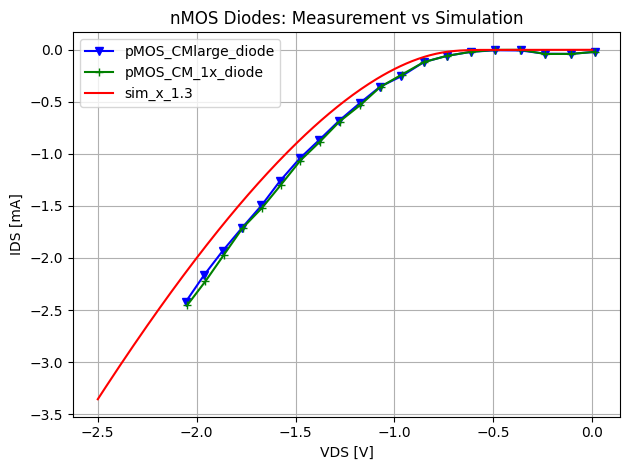

In [9]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

sim_scaling = model_scaling
no_meas = len(data_collection.keys())
fig, ax = plt.subplots()
for index, name in enumerate(data_collection):
    plot_data(ax, data_collection[name], color=next(colors), marker=next(markers)+'-', name=name, R_meas=94/100)
# ax.get_legend().remove()
# plot_data(ax, sim_1x_diode_data['sim'], marker=next(markers), color=next(colors), name="sim", R_meas=1)
plot_data(ax, sim_1x_diode_data['sim'], marker='-', color=next(colors), name=f'sim_x_{sim_scaling}', R_meas=1/sim_scaling)

ax.set_title('nMOS Diodes: Measurement vs Simulation')
fig.tight_layout()

**Observations**:
* The transistors are diode connected so VDS=VGS.
* We get a fairly good correspondence between simulation and measurement if we scale the simulation data up. 
* This seems to indicate that the mobility is higher on the chip than in the simulation and/or the threshold voltage lower; remember that the model used is a public domain model, not even optimized for this technology. 


## pMOS Current-Mirror Devices

Here we evaluate the nMOS current mirror, specifically the 1x, 2x, 4x, 8x and 16x devices. 

### Collecting the Simulation Data

In [10]:
sim_filenames = [ "sims/pmos_IV_4x_1x_IDS_VDS.raw" ]
log_filenames = [ "sims/pmos_IV_4x_1x_IDS_VDS.log" ]
LTR = pyLT.RawRead(sim_filenames[0])
LTL = pyLT.LTSpiceLogReader(log_filenames[0])
step_values = LTL.stepset[LTL.get_step_vars()[0]]
step_values
# LTR.get_trace_names()

[0.75, 1, 1.25, 1.5, 1.75, 2, 2.25]

In [11]:
spice_device_names = {'1x': 'Ix(x12:out1)'} # there is only need for one sim at this point since the scaling is perfect

In [12]:
sim_cm_data = {}
for label, trace_name in spice_device_names.items():
    sim_cm_data[label] = {}
    for step in LTR.get_steps():
        sim_cm_data[label][step] = {}
        sim_cm_data[label][step]['VGS'] = step_values[step]
        sim_cm_data[label][step]['VDS'] = LTR.get_trace("vds").get_wave(step)
        sim_cm_data[label][step]['IDS'] = LTR.get_trace(trace_name).get_wave(step)

### Collecting the Measurement Data

In [13]:
folder = './'
filename = 'pMOS_CM_ids_vds_pm2v5_range.pickle'
file = os.path.join(folder, filename)
if not os.path.exists(file):
    print(f"{file} does not exist -- DATA NOT LOADED")
else:
    with open(file, 'rb') as dbfile_read:
        data_collection_cm = pickle.load(dbfile_read)

In [14]:
data_collection = data_collection_cm
data_collection.keys()

dict_keys(['pMOS_CMlarge_1x', 'pMOS_CMlarge_2x', 'pMOS_CMlarge_4x', 'pMOS_CMlarge_8x', 'pMOS_CMlarge_16x'])

In [15]:
model_scaling = 1.30

### IDS-VDS Measurement vs Simulation

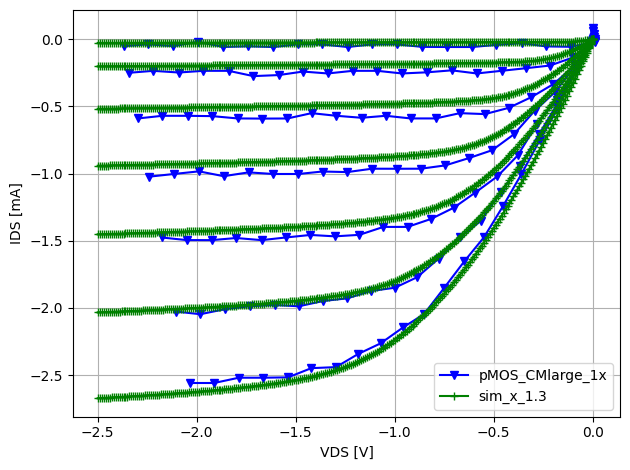

In [16]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

sim_scaling = model_scaling * 1
name = list(data_collection.keys())[0]
fig, ax = plt.subplots()
plot_data(ax, data_collection[name], color=next(colors), marker=next(markers)+'-', name=name, R_meas=94/100)
plot_data(ax, sim_cm_data['1x'], color=next(colors), marker=next(markers)+'-', name=f'sim_x_{sim_scaling}', R_meas=1/sim_scaling)
fig.tight_layout()

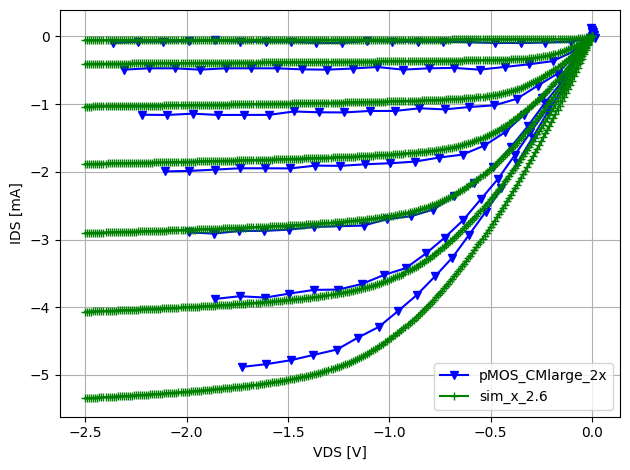

In [17]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

sim_scaling = model_scaling * 2
name = list(data_collection.keys())[1]
fig, ax = plt.subplots()
plot_data(ax, data_collection[name], color=next(colors), marker=next(markers)+'-', name=name, R_meas=94/100)
plot_data(ax, sim_cm_data['1x'], color=next(colors), marker=next(markers)+'-', name=f'sim_x_{sim_scaling}', R_meas=1/sim_scaling)
# ax.get_legend().remove()
fig.tight_layout()

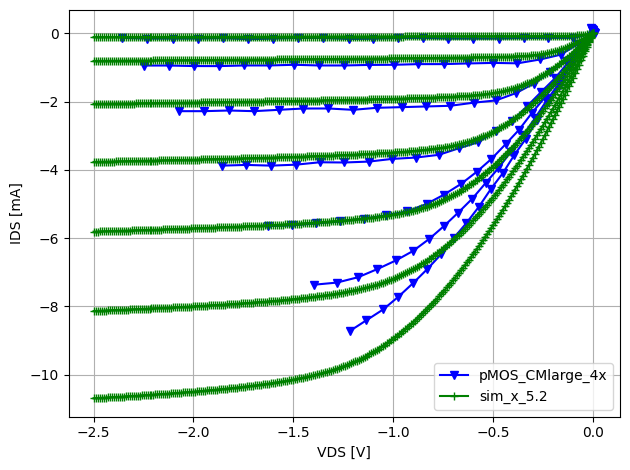

In [18]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

sim_scaling = model_scaling * 4
name = list(data_collection.keys())[2]
fig, ax = plt.subplots()
plot_data(ax, data_collection[name], color=next(colors), marker=next(markers)+'-', name=name, R_meas=94/100)
plot_data(ax, sim_cm_data['1x'], color=next(colors), marker=next(markers)+'-', name=f'sim_x_{sim_scaling}', R_meas=1/sim_scaling)
# ax.get_legend().remove()
fig.tight_layout()

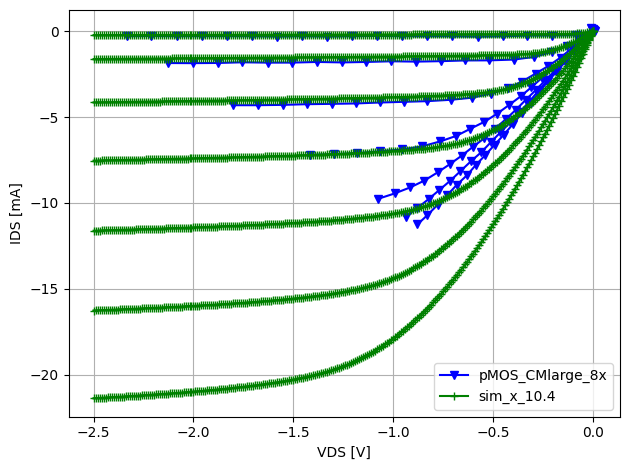

In [19]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

sim_scaling = model_scaling * 8
name = list(data_collection.keys())[3]
fig, ax = plt.subplots()
plot_data(ax, data_collection[name], color=next(colors), marker=next(markers)+'-', name=name, R_meas=94/100)
plot_data(ax, sim_cm_data['1x'], color=next(colors), marker=next(markers)+'-', name=f'sim_x_{sim_scaling}', R_meas=1/sim_scaling)
# ax.get_legend().remove()
fig.tight_layout()

**Observations:**

* The correspondence between measurement and simulation in saturation is remarkably good when the simulation data is scaled up by 30%, especially considering that the public-domain model used is not optimized for this techology.
* The fit in the linear region is less good and reviewed further below. 


### Current Mirror Scaling

In an ideal current mirror the IDS-VDS characteristic scales with the mirror factor. here we plot the 'normalized' currents, so e.g. for the 8x device we plot IDS/8, and so on. To the first order, the characteristics should overlap. (In the layout good practices were applied to get accurate current mirror factors.)

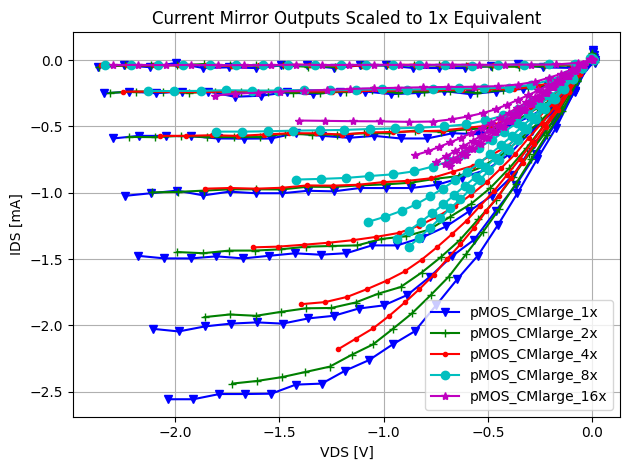

In [20]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

no_meas = len(data_collection.keys())
fig, ax = plt.subplots()
for index, name in enumerate(data_collection):
    plot_data(ax, data_collection[name], color=next(colors), marker=next(markers)+'-', name=name, R_meas=94/100*2**index)
ax.set_title('Current Mirror Outputs Scaled to 1x Equivalent')
fig.tight_layout()

**Observations:**

* In saturation the overlap is very good, especially given the limited accuracy of our setup.
* In the linear region the smaller transistor sizes overlap but the larger transistors do not.

#### Looking at Parasitic Resistance

In the linear region, especially for the larger devices, the IDS-VDS characteristic measurement is sensitive to possible series resistance since the $R_{ds}$ of the devices becomes small. We notice that as the VSG increases (and thus the $R_{ds}$ reduces), the |IDS| does not increase in the linear region, seeming to indicate the presence of a parasitic series resistor. Here we estimate the value of those resistors. 

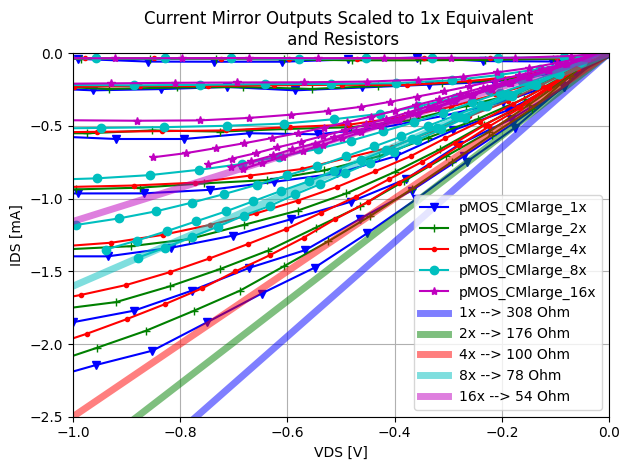

In [21]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

no_meas = len(data_collection.keys())
fig, ax = plt.subplots()
for index, name in enumerate(data_collection):
    plot_data(ax, data_collection[name], color=next(colors), marker=next(markers)+'-', name=name, R_meas=94/100*2**index)

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 
for res, dev_scale in [(308, 1), (176, 2), (100, 4), (78, 8), (54, 16)]:
    vds = np.arange(0, -2.0, -0.05)
    ids_r = vds/res/dev_scale*1000
    ax.plot(vds, ids_r, '-', color=next(colors), label=f'{dev_scale}x --> {res} Ohm', lw=5, alpha=0.5)

ax.legend()
ax.set_title('Current Mirror Outputs Scaled to 1x Equivalent \n and Resistors')
ax.set_xlim((-1.0, 0))
ax.set_ylim((-2.5, 0))
fig.tight_layout()

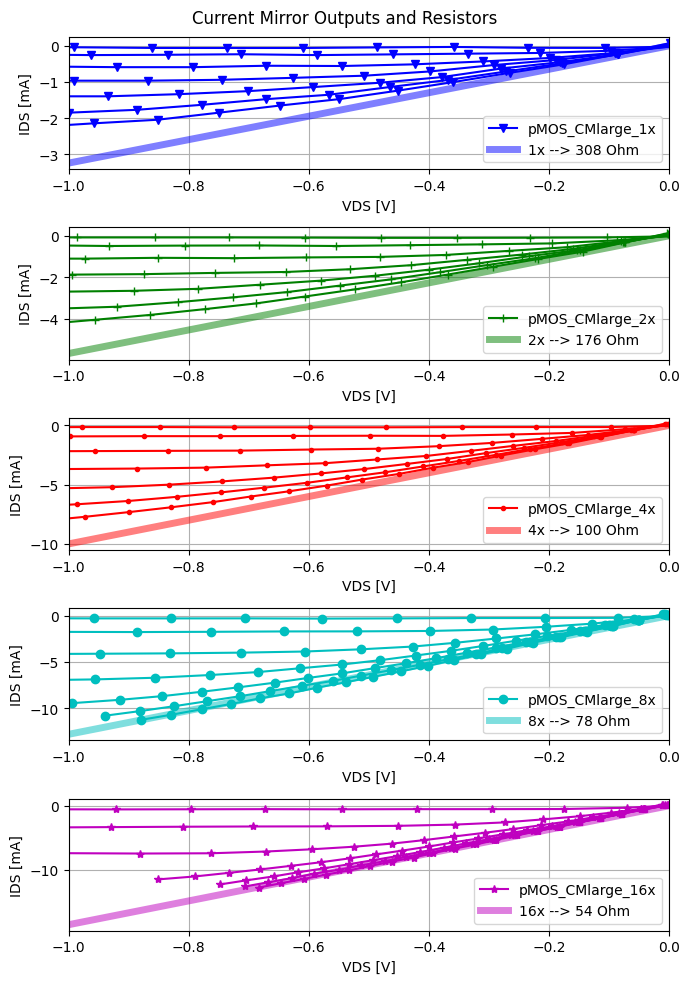

In [22]:
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k']) 
markers = itertools.cycle(('v', '+', '.', 'o', '*', "s")) 

no_meas = len(data_collection.keys())
fig, ax3 = plt.subplots(no_meas, figsize=(7,10))
for index, name in enumerate(data_collection):
    ax=ax3[index]
    color=next(colors)
    marker=next(markers)
    plot_data(ax, data_collection[name], color=color, marker=marker+'-', name=name, R_meas=94/100)
    res, dev_scale = [(308, 1), (176, 2), (100, 4), (78, 8), (54, 16)][index]
    vds = np.arange(-1.0, 0.05, 0.05)
    ids_r = vds/res*1000
    ax.plot(vds, ids_r, '-', color=color, label=f'{dev_scale}x --> {res} Ohm', lw=5, alpha=0.5)
    ax.set_xlim((-1.0, 0))
    # ax.set_ylim((-2.5, 0))
    ax.legend()

plt.suptitle('Current Mirror Outputs and Resistors')

fig.tight_layout()

**Observations:**

* There are series resistors placed for ESD reasons on the pins (e.g. $\approx 12.5\Omega$ for the 8x device, see chip description), but they were nominally designed to be smaller than the values found here.
* Possibly additional routing parasitics or measurement parasitics play a role here. 